In [33]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jeju-dataset/sample_submission.csv
/kaggle/input/jeju-dataset/train.csv
/kaggle/input/jeju-dataset/test.csv
/kaggle/input/jeju-dataset/international_trade.csv
/kaggle/input/jeju-dataset-2/sample_submission.csv
/kaggle/input/jeju-dataset-2/train.csv
/kaggle/input/jeju-dataset-2/test.csv
/kaggle/input/jeju-dataset-2/international_trade.csv


In [34]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = '/kaggle/input/jeju-dataset-2/'

SEED = 42

train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [35]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer

In [36]:
SEED=42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

In [37]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = '/kaggle/input/jeju-dataset-2/'

SEED = 42

train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')

In [38]:
train_df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'}, inplace=True)
train_df

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


## 시간 Feature

In [39]:
# 공휴일
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

In [40]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = train_df['timestamp'].dt.year
train_df['week'] = train_df['timestamp'].dt.isocalendar().week
train_df['day'] = train_df['timestamp'].dt.day
train_df['month_ori'] = train_df['timestamp'].dt.month
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
train_df['sin_week'] = np.sin(2 * np.pi * train_df['week'] / 4)
train_df['cos_week'] = np.cos(2 * np.pi * train_df['week'] / 4)
train_df['sin_dayofweek'] = np.sin(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['cos_dayofweek'] = np.cos(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['week'] = test_df['timestamp'].dt.isocalendar().week
test_df['day'] = test_df['timestamp'].dt.day
test_df['month_ori'] = test_df['timestamp'].dt.month
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek
test_df['sin_week'] = np.sin(2 * np.pi * test_df['week'] / 4)
test_df['cos_week'] = np.cos(2 * np.pi * test_df['week'] / 4)
test_df['sin_dayofweek'] = np.sin(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['cos_dayofweek'] = np.cos(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [41]:
train_df['month'] = train_df['timestamp'].dt.to_period('M')
test_df['month'] = test_df['timestamp'].dt.to_period('M')

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,month_ori,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1,1.0,0.0,0.974928,-0.222521,1,2019-01
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,1,2,1.0,0.0,0.433884,-0.900969,0,2019-01
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,1,3,1.0,0.0,-0.433884,-0.900969,0,2019-01
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,1,4,1.0,0.0,-0.974928,-0.222521,0,2019-01
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,1,5,1.0,0.0,-0.781831,0.623490,1,2019-01


In [42]:
item_month_price = train_df.groupby(['item', 'month'])
agg = {'price' : ['mean', 'max']}
price_df = item_month_price.agg(agg).reset_index()
price_df

item    month        price        
                          mean     max
0     BC  2019-01  1278.086022  2689.0
1     BC  2019-02  1152.563492  2925.0
2     BC  2019-03  1772.620072  4149.0
3     BC  2019-04  2288.400000  6929.0
4     BC  2019-05   658.265233  5965.0
..   ...      ...          ...     ...
250   TG  2022-11  1361.850000  2526.0
251   TG  2022-12  1696.103226  4202.0
252   TG  2023-01  1782.693548  8000.0
253   TG  2023-02  2250.250000  8500.0
254   TG  2023-03  3442.633333  6382.0

[255 rows x 4 columns]

In [43]:
price_df.columns = ['item', 'month', 'month_price_mean', 'month_price_max']
train_df = pd.merge(train_df, price_df, on=['item', 'month'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,month_ori,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1,1.0,0.0,0.974928,-0.222521,1,2019-01,1485.383871,4031.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,1,2,1.0,0.0,0.433884,-0.900969,0,2019-01,1485.383871,4031.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,1,3,1.0,0.0,-0.433884,-0.900969,0,2019-01,1485.383871,4031.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,1,4,1.0,0.0,-0.974928,-0.222521,0,2019-01,1485.383871,4031.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,1,5,1.0,0.0,-0.781831,0.623490,1,2019-01,1485.383871,4031.0


In [44]:
# 테스트셋 반영
test_df = pd.merge(test_df, price_df, on=['item', 'month'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,week,day,month_ori,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,9,4,3,5,1.0,0.0,-7.818315e-01,0.623490,1,2023-03,3442.633333,6382.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,9,5,3,6,1.0,0.0,-2.449294e-16,1.000000,1,2023-03,3442.633333,6382.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,10,6,3,0,0.0,-1.0,7.818315e-01,0.623490,0,2023-03,3442.633333,6382.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,10,7,3,1,0.0,-1.0,9.749279e-01,-0.222521,0,2023-03,3442.633333,6382.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,10,8,3,2,0.0,-1.0,4.338837e-01,-0.900969,0,2023-03,3442.633333,6382.0


In [45]:
item_month_supply = train_df.groupby(['item', 'month'])
agg = {'supply' : ['mean', 'max']}
supply_df = item_month_supply.agg(agg).reset_index()
supply_df

item    month        supply          
                           mean       max
0     BC  2019-01   2494.161290   14584.0
1     BC  2019-02   2288.412698   15184.0
2     BC  2019-03   2056.946237   14048.0
3     BC  2019-04   1347.229630   10136.0
4     BC  2019-05    124.301075    3792.0
..   ...      ...           ...       ...
250   TG  2022-11  29303.189000  104781.0
251   TG  2022-12  34294.561290  129891.0
252   TG  2023-01  27517.410968  127048.0
253   TG  2023-02  19588.908571   78797.0
254   TG  2023-03  16526.743333   47819.0

[255 rows x 4 columns]

In [46]:
supply_df.columns = ['item', 'month', 'month_supply_mean', 'month_supply_max']
train_df = pd.merge(train_df, supply_df, on=['item', 'month'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,1.0,0.0,0.974928,-0.222521,1,2019-01,1485.383871,4031.0,47433.957097,268073.4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,...,1.0,0.0,0.433884,-0.900969,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,...,1.0,0.0,-0.433884,-0.900969,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,...,1.0,0.0,-0.974928,-0.222521,0,2019-01,1485.383871,4031.0,47433.957097,268073.4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,...,1.0,0.0,-0.781831,0.623490,1,2019-01,1485.383871,4031.0,47433.957097,268073.4


In [47]:
# 테스트셋 반영
test_df = pd.merge(test_df, supply_df, on=['item', 'month'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,week,day,month_ori,day_of_week,sin_week,cos_week,sin_dayofweek,cos_dayofweek,holiday,month,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,9,4,3,5,1.0,0.0,-7.818315e-01,0.623490,1,2023-03,3442.633333,6382.0,16526.743333,47819.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,9,5,3,6,1.0,0.0,-2.449294e-16,1.000000,1,2023-03,3442.633333,6382.0,16526.743333,47819.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,10,6,3,0,0.0,-1.0,7.818315e-01,0.623490,0,2023-03,3442.633333,6382.0,16526.743333,47819.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,10,7,3,1,0.0,-1.0,9.749279e-01,-0.222521,0,2023-03,3442.633333,6382.0,16526.743333,47819.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,10,8,3,2,0.0,-1.0,4.338837e-01,-0.900969,0,2023-03,3442.633333,6382.0,16526.743333,47819.0


In [48]:
# 공급과 가격의 상관관계
sup_price_corr = train_df['supply'].corr(train_df['price'])
sup_price_corr

-0.0022967366004861545

In [49]:
# timestamp
train_df['timestamp'] = (train_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_df['timestamp'] = (test_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

train_df['timestamp']

0        1546300800
1        1546387200
2        1546473600
3        1546560000
4        1546646400
            ...    
59392    1677456000
59393    1677542400
59394    1677628800
59395    1677715200
59396    1677801600
Name: timestamp, Length: 59397, dtype: int64

In [50]:
# month
train_df['month'] = (train_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_df['month'] = (test_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

test_df['month']

0       1677628800
1       1677628800
2       1677628800
3       1677628800
4       1677628800
           ...    
1087    1677628800
1088    1677628800
1089    1677628800
1090    1677628800
1091    1677628800
Name: month, Length: 1092, dtype: int64

In [51]:
international = pd.read_csv(f'{DATA_PATH}international_trade.csv')


In [52]:
international = international.rename(columns={
    '기간': 'month',
    '품목명': 'item',
    '수출 중량': 'exWeight',
    '수출 금액': 'exValue',
    '수입 중량': 'imWeight',
    '수입 금액': 'imValue',
    '무역수지': 'tradeBalance'
})

international.head()

,month,item,exWeight,exValue,imWeight,imValue,tradeBalance
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [53]:
international['month'] = pd.to_datetime(international['month'], format='%Y-%m')
international['month'] = (international['month'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [54]:
selected_items = international[international['item'].str.contains('감귤|브로콜리|무|당근|양배추')].copy()

selected_items['item'] = selected_items['item'].replace({
    '감귤': 'TG',
    '브로콜리': 'BC',
    '무': 'RD',
    '당근': 'CR',
    '양배추': 'CB'
}, regex = True)

selected_items['item'] = selected_items['item'].str.replace('.*감귤.*', 'TG')
selected_items['item'] = selected_items['item'].str.replace('.*브로콜리.*', 'BC')
selected_items['item'] = selected_items['item'].str.replace('.*무.*', 'RD')
selected_items['item'] = selected_items['item'].str.replace('.*당근.*', 'CR')
selected_items['item'] = selected_items['item'].str.replace('.*양배추.*', 'CB')

selected_items

,month,item,exWeight,exValue,imWeight,imValue,tradeBalance
3,1546300800,꽃CB와 BC(broccoli),160,1,638913,563,-562
4,1546300800,방울다다기 CB,0,0,7580,38,-38
5,1546300800,CB,184650,94,395802,90,4
8,1546300800,CR,23150,22,7466150,2955,-2934
12,1546300800,RD화과,2627,23,94529,464,-441
...,...,...,...,...,...,...,...
1250,1675209600,CB,13188,13,377456,104,-91
1253,1675209600,CR,22510,20,9260020,3758,-3737
1254,1675209600,순RD,4000,4,2,0,4
1258,1675209600,RD화과,1319,14,104566,454,-440


In [55]:
train_df = train_df.merge(selected_items, on=['month', 'item'], how='left')
test_df = test_df.merge(selected_items, on=['month', 'item'], how='left')


train_df['exPrice'] = train_df['exValue'] / train_df['exWeight']
train_df['imPrice'] = train_df['imValue'] / train_df['imWeight']

test_df['exPrice'] = test_df['exValue'] / test_df['exWeight']
test_df['imPrice'] = test_df['imValue'] / test_df['imWeight']

train_df

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,month_price_max,month_supply_mean,month_supply_max,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,2019,1,2,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,2019,1,3,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,2019,1,4,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,2019,1,5,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,2023,9,27,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,2023,9,28,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,2023,9,1,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,2023,9,2,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [57]:
# 품목별 평균 가격
item_mean_price = train_df.groupby('item')['price'].mean().reset_index()
item_mean_price.columns = ['item', 'item_mean_price']

train_df = train_df.merge(item_mean_price, on='item', how='left')
test_df = test_df.merge(item_mean_price, on='item', how='left')

# 법인별 평균 가격
corp_mean_price = train_df.groupby('corporation')['price'].mean().reset_index()
corp_mean_price.columns = ['corporation', 'corp_mean_price']

train_df = train_df.merge(corp_mean_price, on='corporation', how='left')
test_df = test_df.merge(corp_mean_price, on='corporation', how='left')

# 지역별 평균 가격
location_mean_price = train_df.groupby('location')['price'].mean().reset_index()
location_mean_price.columns = ['location', 'location_mean_price']

train_df = train_df.merge(location_mean_price, on='location', how='left')
test_df = test_df.merge(location_mean_price, on='location', how='left')

In [58]:
obj_cols = ['item', 'corporation', 'location']

for col in obj_cols:
    enc = LabelEncoder()
    train_df[col]=enc.fit_transform(train_df[col])
    test_df[col]=enc.transform(test_df[col])

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,week,day,...,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price
0,TG_A_J_20190101,1546300800,4,0,0,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
1,TG_A_J_20190102,1546387200,4,0,0,0.0,0.0,2019,1,2,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
2,TG_A_J_20190103,1546473600,4,0,0,60601.0,1728.0,2019,1,3,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
3,TG_A_J_20190104,1546560000,4,0,0,25000.0,1408.0,2019,1,4,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
4,TG_A_J_20190105,1546646400,4,0,0,32352.0,1250.0,2019,1,5,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148


In [59]:
train_df['week'] = train_df['week'].astype(float)
test_df['week'] = test_df['week'].astype(float)

In [60]:
train_df['sin_week'] =train_df['sin_week'].astype(float)
train_df['cos_week'] =train_df['cos_week'].astype(float)

test_df['sin_week'] =test_df['sin_week'].astype(float)
test_df['cos_week'] =test_df['cos_week'].astype(float)

In [61]:
# 10분위수로 카테고리화 하기 

# 10분위수로 나누기

train_df['price_category'] = pd.qcut(train_df['price'], q=10, labels=False, duplicates='drop')
train_df['supply_category'] = pd.qcut(train_df['supply'], q=10, labels=False, duplicates='drop')


# 각 구간의 평균값 계산
mean_values = train_df.groupby('price_category')['price'].mean()
train_df['price_category_mean'] = train_df['price_category'].map(mean_values)

# 각 구간의 평균값 계산
mean_values = train_df.groupby('supply_category')['supply'].mean()
train_df['supply_category_mean'] = train_df['supply_category'].map(mean_values)


In [62]:
# 훈련 데이터에서 각 조합에서의 최빈 구간을 찾아서 매핑
item_price_mode = train_df.groupby(['item', 'month_ori','day_of_week'])['price_category'].apply(lambda x: x.mode().iloc[0])
item_supply_mode = train_df.groupby(['item','month_ori','day_of_week'])['supply_category'].apply(lambda x: x.mode().iloc[0])

test_df['price_category'] = test_df.apply(lambda row: item_price_mode.get((row['item'], row['month_ori'], row['day_of_week']), None), axis=1)
test_df['supply_category'] = test_df.apply(lambda row: item_supply_mode.get((row['item'], row['month_ori'], row['day_of_week']), None), axis=1)

mean_values_price = train_df.groupby('price_category')['price'].mean()
mean_values_supply = train_df.groupby('supply_category')['supply'].mean()

# 테스트 데이터에 평균값 추가
test_df['price_category_mean'] = test_df['price_category'].map(mean_values_price)
test_df['supply_category_mean'] = test_df['supply_category'].map(mean_values_supply)


In [82]:
train_df['price_category_mean'] = np.log(train_df['price_category_mean'])
train_df['supply_category_mean'] = np.log(train_df['supply_category_mean'])

test_df['price_category_mean'] = np.log(test_df['price_category_mean'])
test_df['supply_category_mean'] = np.log(test_df['supply_category_mean'])


In [83]:
test_df

,ID,timestamp,item,corporation,location,year,week,day,month_ori,day_of_week,...,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price,price_category,supply_category,price_category_mean,supply_category_mean,name
0,TG_A_J_20230304,1677888000,4,0,0,2023,9.0,4,3,5,...,0.0,0.0,3177.442022,1141.704458,1062.35148,3,2,7.965954,8.273928,TG_A_J
1,TG_A_J_20230305,1677974400,4,0,0,2023,9.0,5,3,6,...,0.0,0.0,3177.442022,1141.704458,1062.35148,0,0,0.153236,-1.686708,TG_A_J
2,TG_A_J_20230306,1678060800,4,0,0,2023,10.0,6,3,0,...,0.0,0.0,3177.442022,1141.704458,1062.35148,4,2,8.753567,8.273928,TG_A_J
3,TG_A_J_20230307,1678147200,4,0,0,2023,10.0,7,3,1,...,0.0,0.0,3177.442022,1141.704458,1062.35148,4,2,8.753567,8.273928,TG_A_J
4,TG_A_J_20230308,1678233600,4,0,0,2023,10.0,8,3,2,...,0.0,0.0,3177.442022,1141.704458,1062.35148,4,2,8.753567,8.273928,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,1679875200,3,5,0,2023,13.0,27,3,0,...,0.0,0.0,187.073539,259.121799,1062.35148,1,4,6.343372,11.520248,RD_F_J
1088,RD_F_J_20230328,1679961600,3,5,0,2023,13.0,28,3,1,...,0.0,0.0,187.073539,259.121799,1062.35148,1,3,6.343372,9.520724,RD_F_J
1089,RD_F_J_20230329,1680048000,3,5,0,2023,13.0,29,3,2,...,0.0,0.0,187.073539,259.121799,1062.35148,1,3,6.343372,9.520724,RD_F_J
1090,RD_F_J_20230330,1680134400,3,5,0,2023,13.0,30,3,3,...,0.0,0.0,187.073539,259.121799,1062.35148,1,3,6.343372,9.520724,RD_F_J


In [84]:
train_df.shape, test_df.shape

((59397, 37), (1092, 35))

In [85]:
# 불필요 컬럼 제거
X = train_df.drop(columns=['ID', 'price', 'supply'])
y = train_df['price']

test_X = test_df.drop(columns=['ID'])

X.shape, y.shape, test_X.shape

((59397, 34), (59397,), (1092, 34))

In [86]:
test_df['month'].unique()

array([1677628800])

## 검증 및 예측

## 상품별 데이터 예측 (39개)


In [69]:
!pip install sktime

  Obtaining dependency information for sktime from https://files.pythonhosted.org/packages/76/59/a61df85f9e36a2174e544f99e87be4d62e1f502216db2cb3e75be8e7174b/sktime-0.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-base<0.7.0 from https://files.pythonhosted.org/packages/ba/5d/cf3d9ae370bc67f6d81f54a7f80656ef5b88635f67fb2339f1a0eb666551/scikit_base-0.6.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 49.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 11.7 MB/s eta 0:00:00


In [70]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series


In [71]:
train_df['name'] = train_df['ID'].apply(lambda x : x[:6])
test_df['name'] = test_df['ID'].apply(lambda x : x[:6])


In [72]:
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [73]:
# !pip install catboost

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


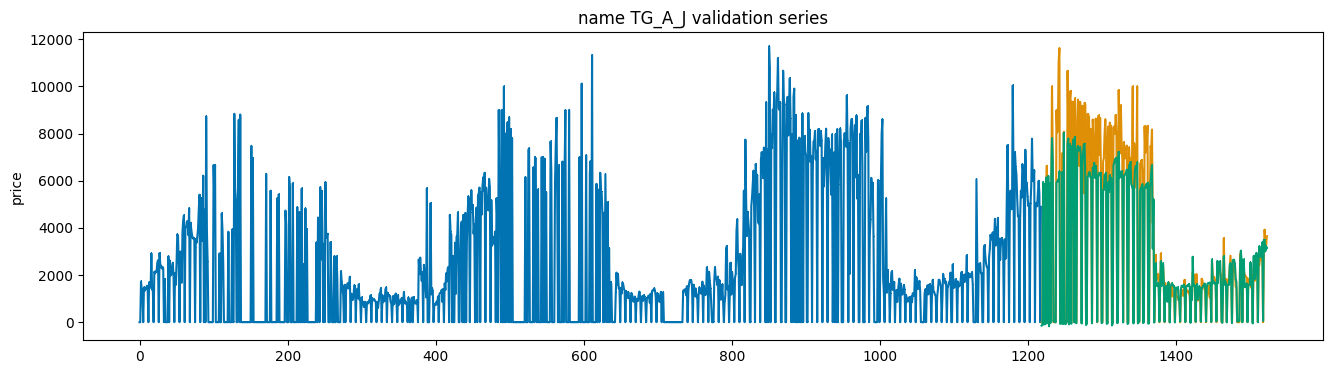

RMSE: 233.25425520893074


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  3%|▎         | 1/39 [00:22<14:09, 22.36s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

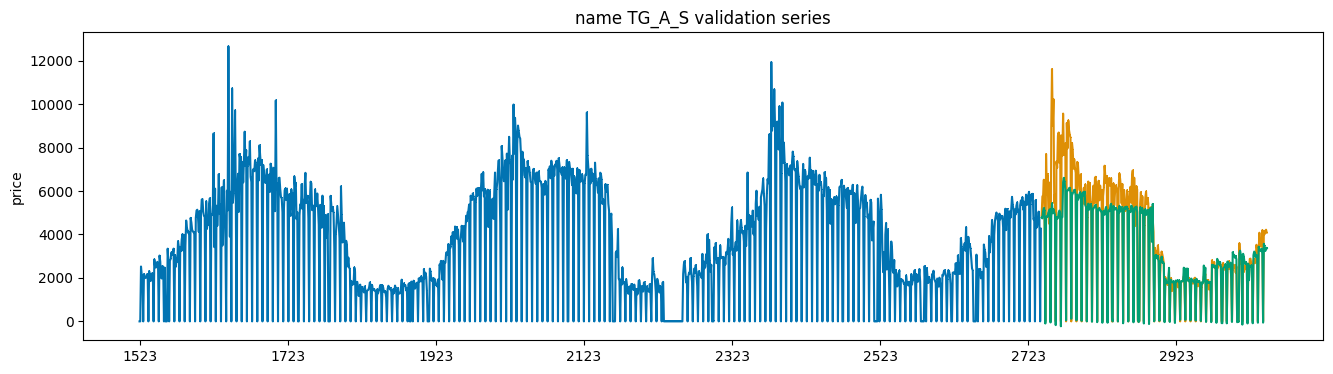

RMSE: 220.90195202132958


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  5%|▌         | 2/39 [00:45<14:08, 22.95s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

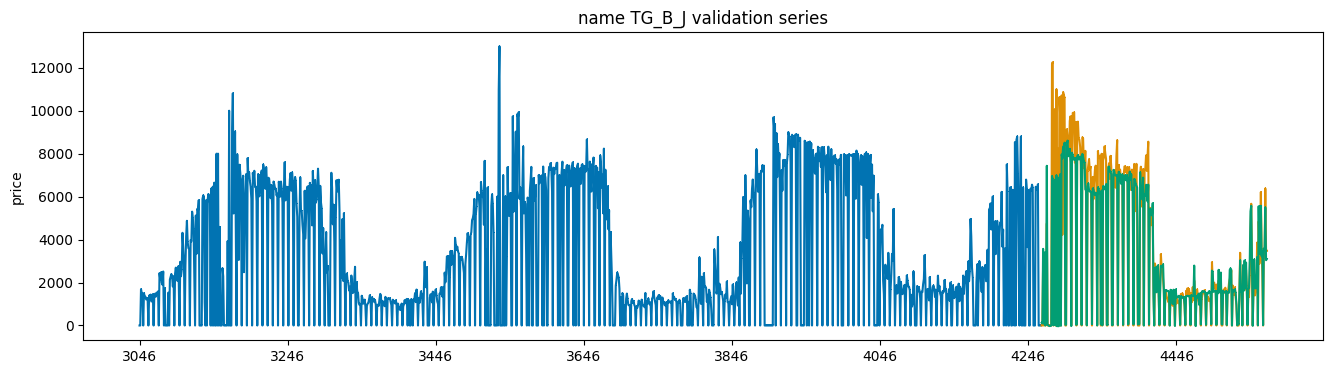

RMSE: 274.36845169231583


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
  8%|▊         | 3/39 [01:09<13:52, 23.11s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

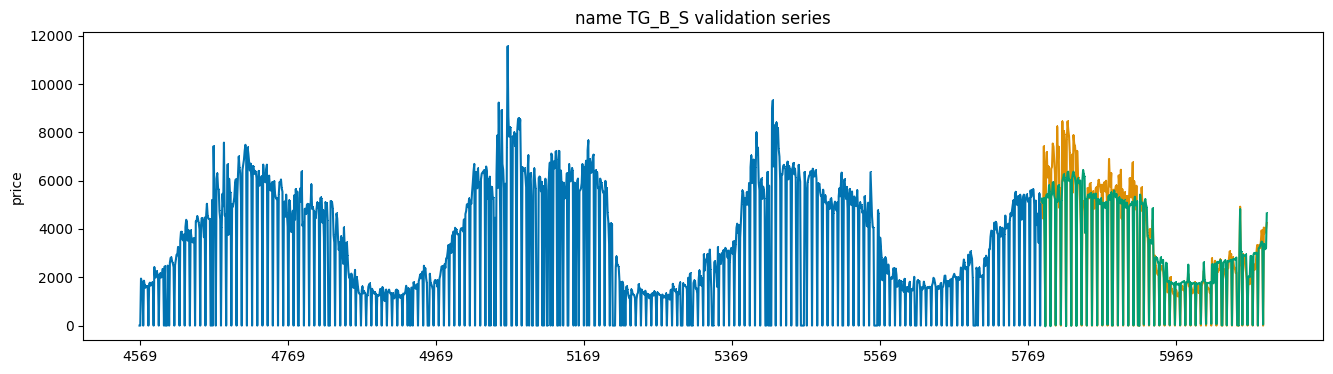

RMSE: 152.85328842232354


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 10%|█         | 4/39 [01:33<13:51, 23.75s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

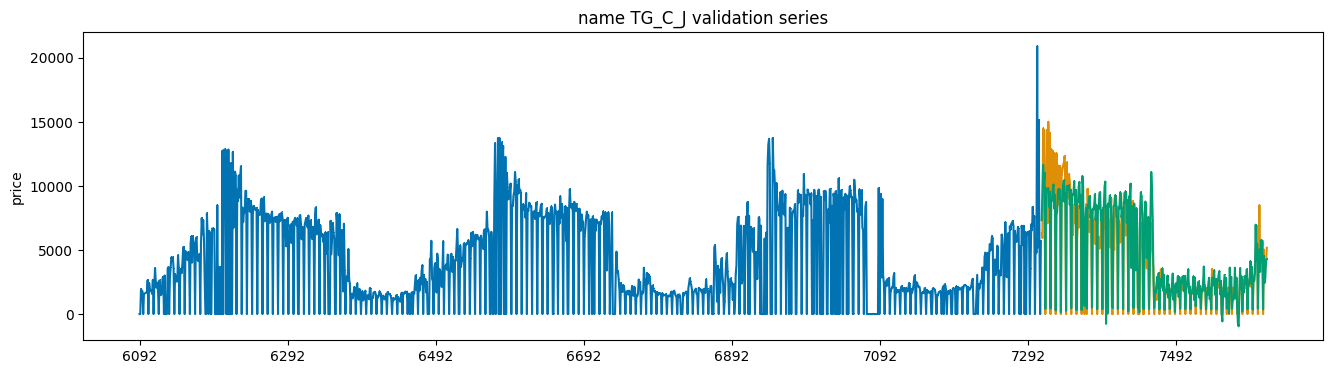

RMSE: 548.5989308814244


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 13%|█▎        | 5/39 [01:57<13:22, 23.62s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

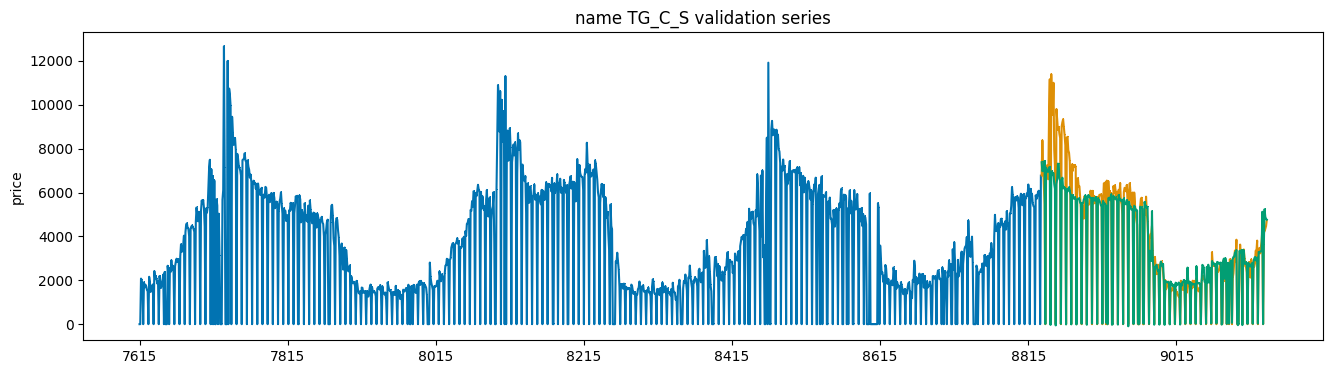

RMSE: 139.8074035316624


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 15%|█▌        | 6/39 [02:19<12:49, 23.31s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

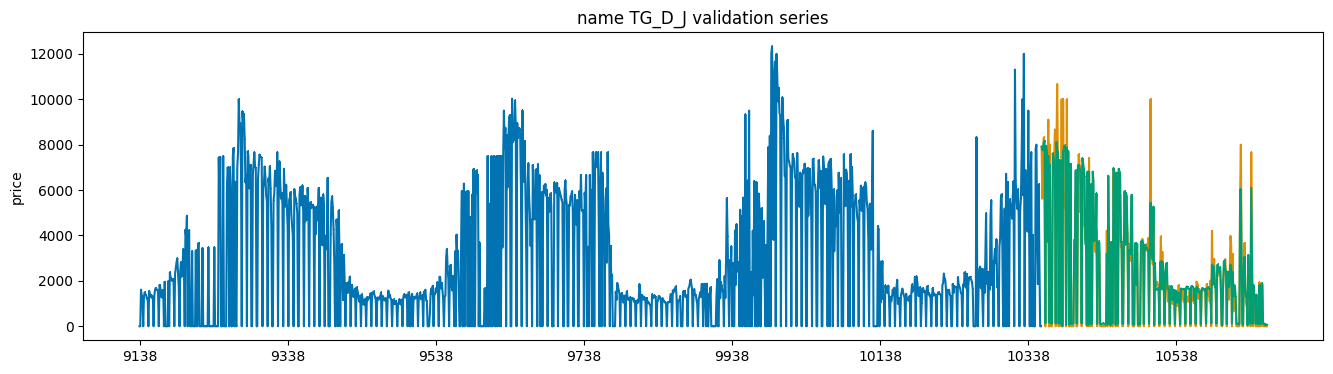

RMSE: 277.216714486492


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 18%|█▊        | 7/39 [02:43<12:32, 23.52s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

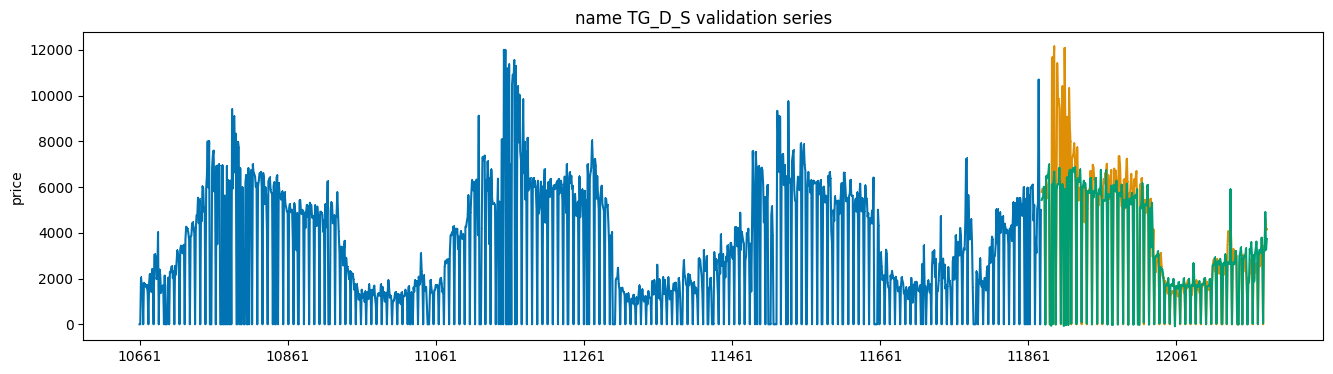

RMSE: 218.07385106726005


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 21%|██        | 8/39 [03:07<12:07, 23.48s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

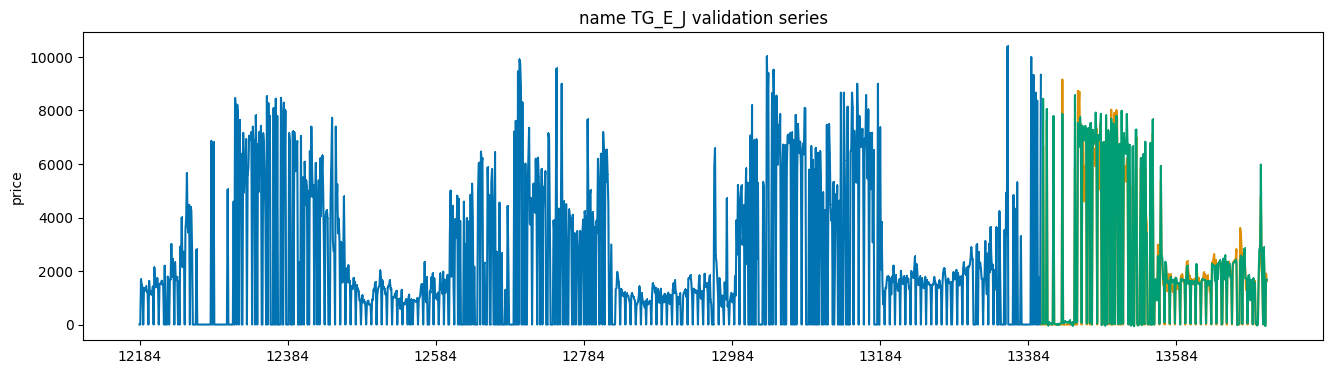

RMSE: 173.64745598445577


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 23%|██▎       | 9/39 [03:30<11:39, 23.31s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

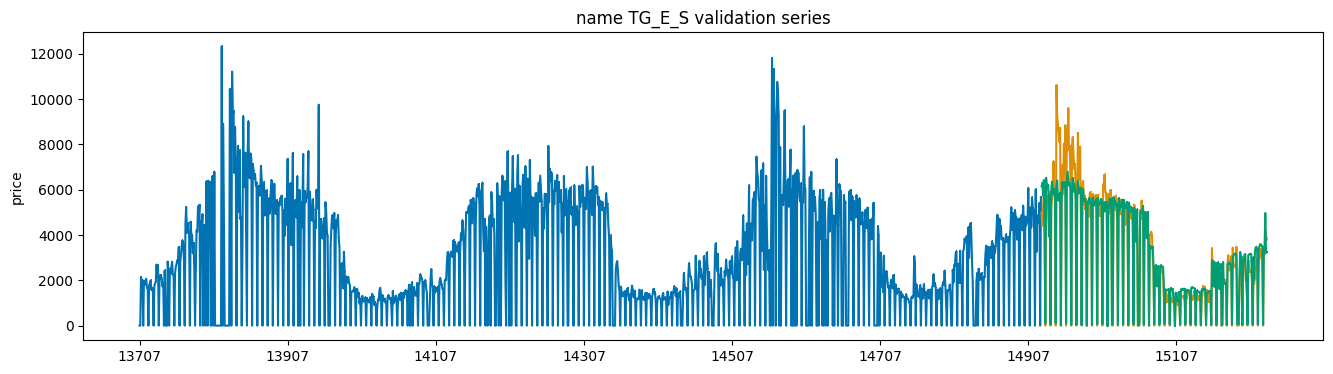

RMSE: 292.9366599852886


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 26%|██▌       | 10/39 [03:53<11:16, 23.33s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

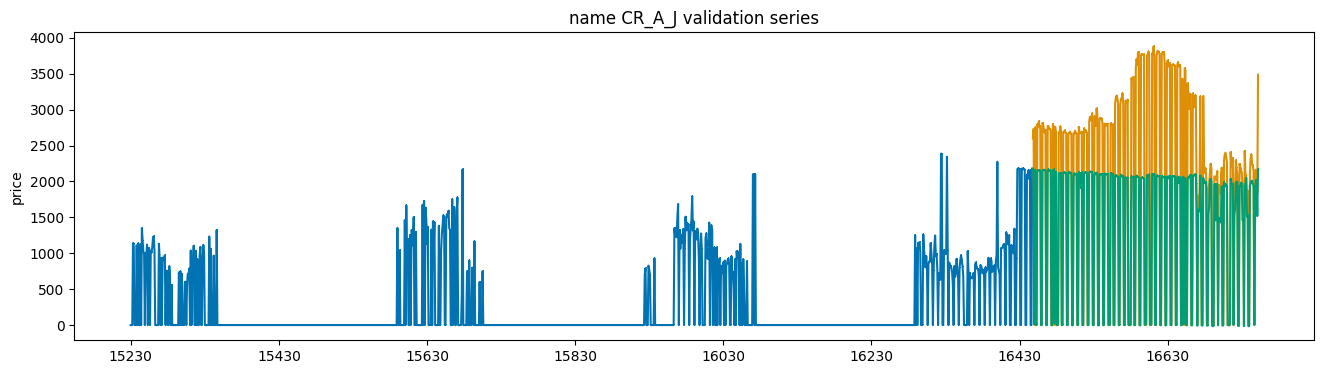

RMSE: 13.966242458115248


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 28%|██▊       | 11/39 [04:11<10:07, 21.69s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

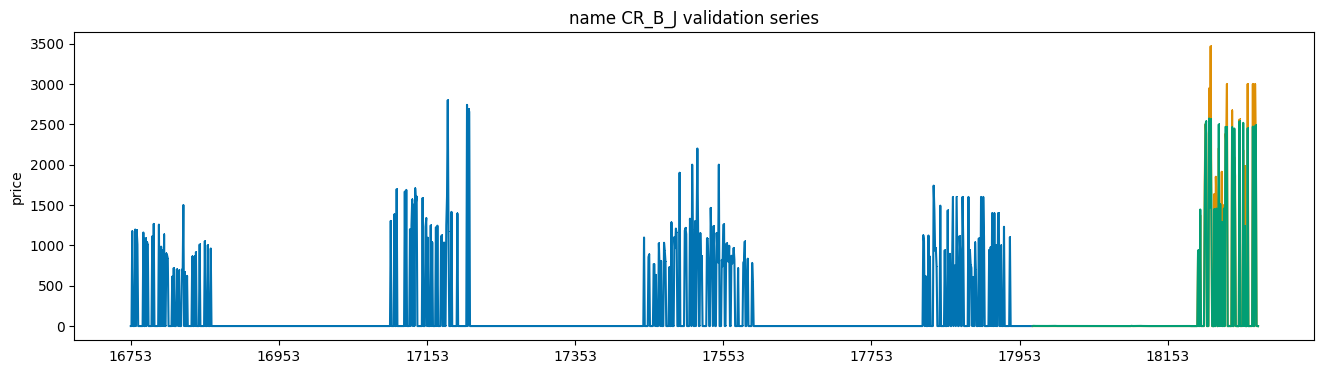

RMSE: 20.43561997803337


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 31%|███       | 12/39 [04:27<09:00, 20.04s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

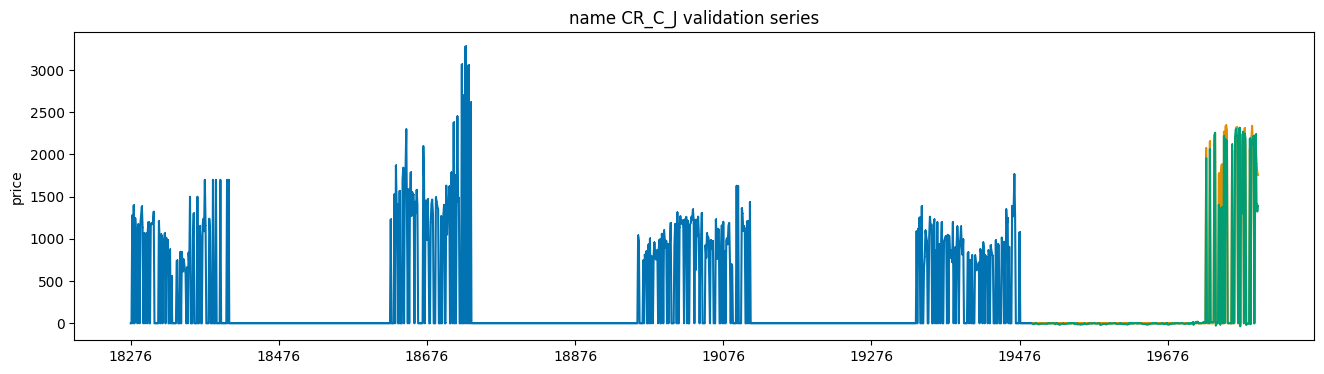

RMSE: 21.36982126083268


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 33%|███▎      | 13/39 [04:44<08:13, 18.98s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

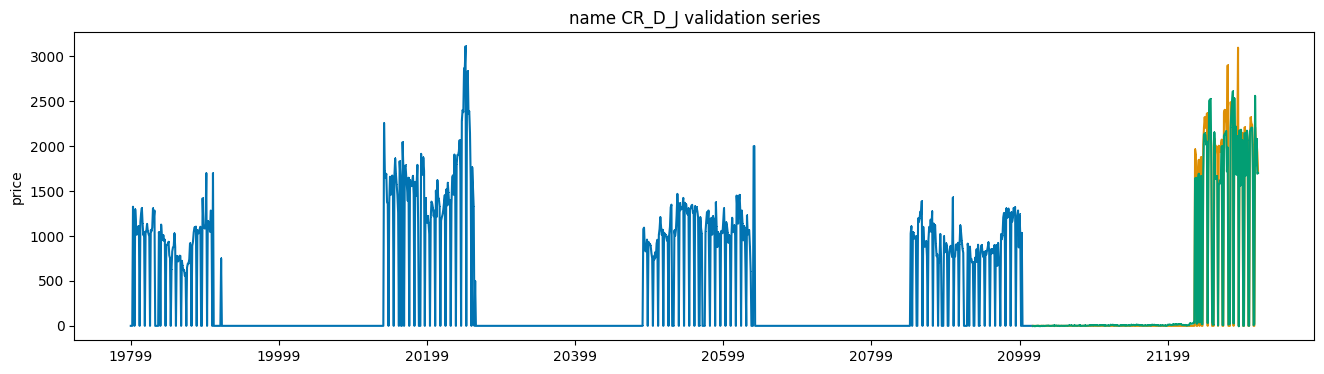

RMSE: 26.137334359903306


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 36%|███▌      | 14/39 [05:03<07:58, 19.16s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

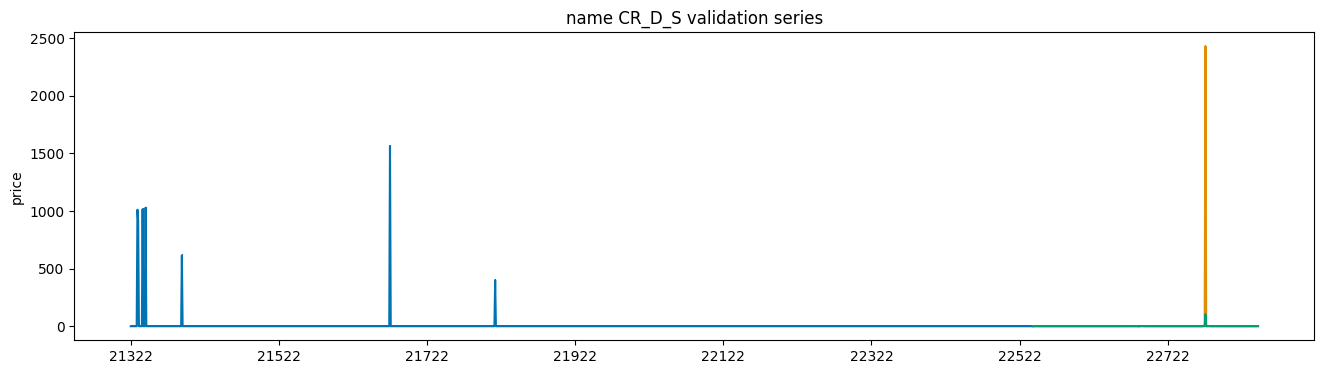

RMSE: 39.84690457059431


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 38%|███▊      | 15/39 [05:17<06:59, 17.47s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

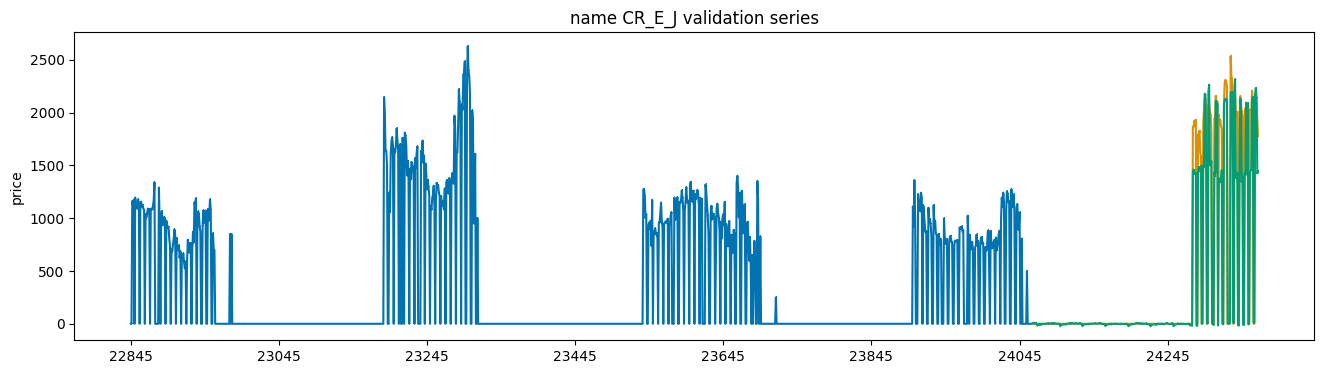

RMSE: 22.63456399124148


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 41%|████      | 16/39 [05:36<06:54, 18.01s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

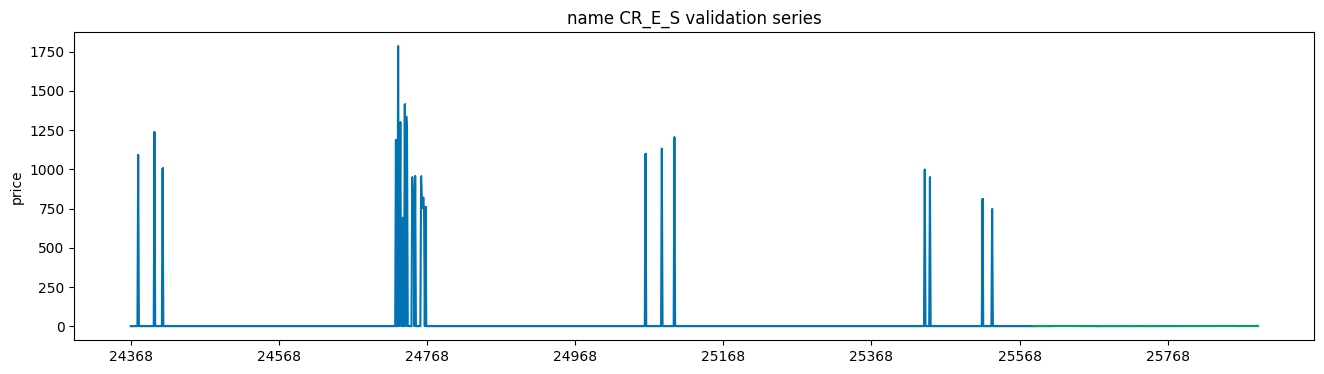

RMSE: 10.92183336783727


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 44%|████▎     | 17/39 [05:50<06:06, 16.66s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

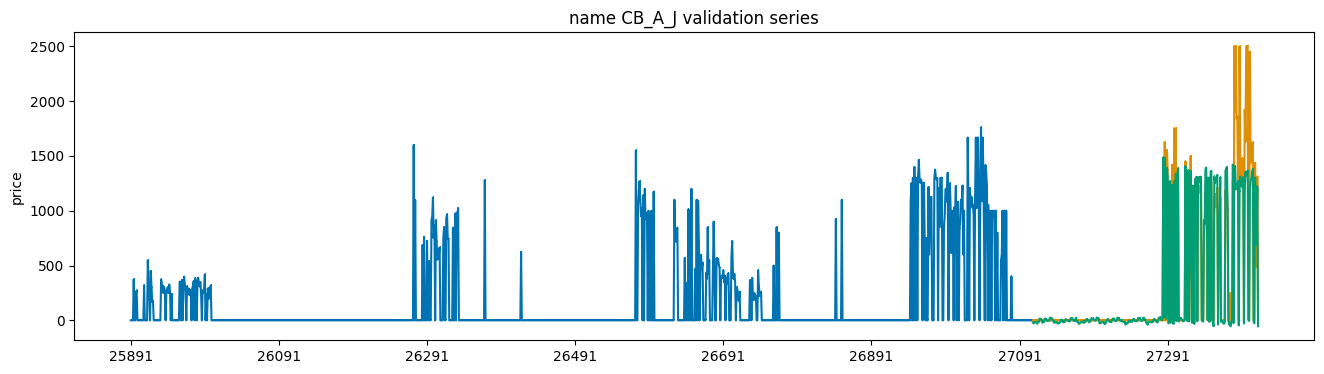

RMSE: 41.63476662492837


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 46%|████▌     | 18/39 [06:07<05:54, 16.86s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

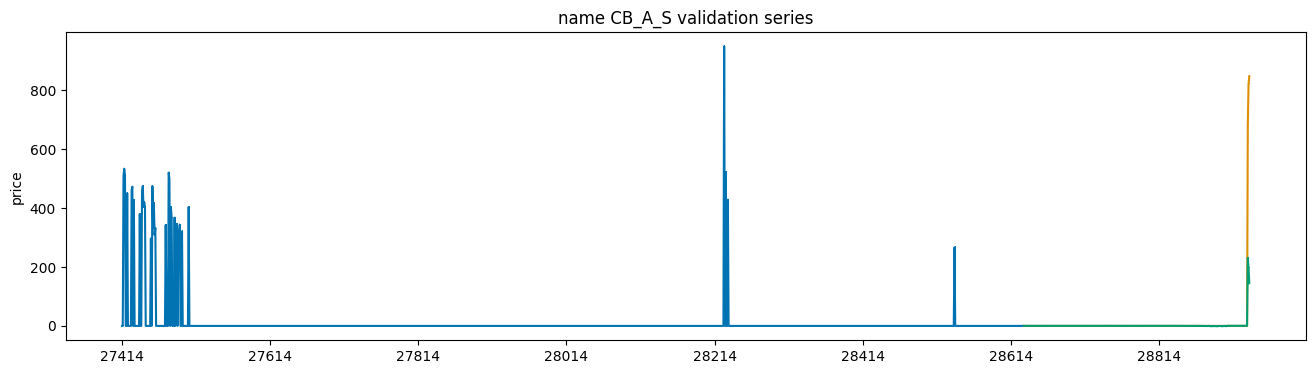

RMSE: 4.211204667101892


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 49%|████▊     | 19/39 [06:21<05:17, 15.88s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

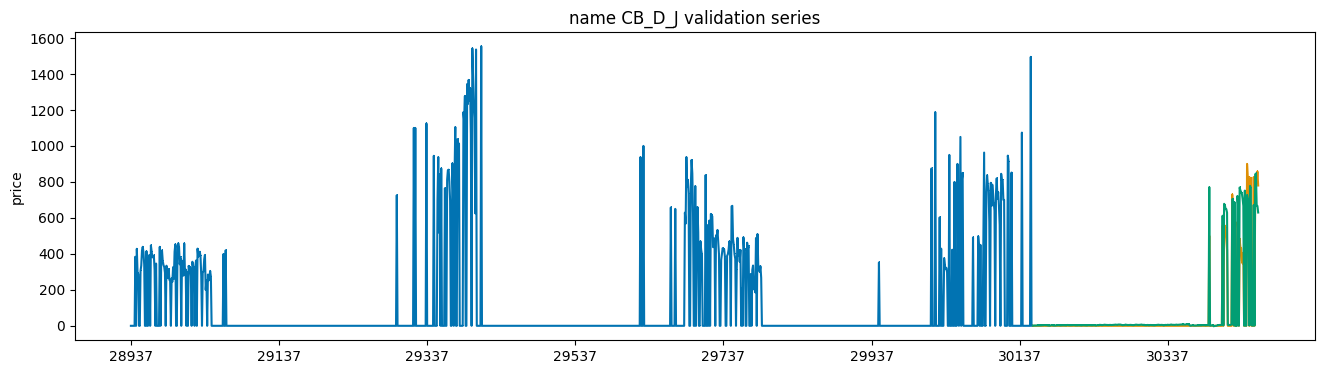

RMSE: 17.323940017291246


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 51%|█████▏    | 20/39 [06:39<05:15, 16.60s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

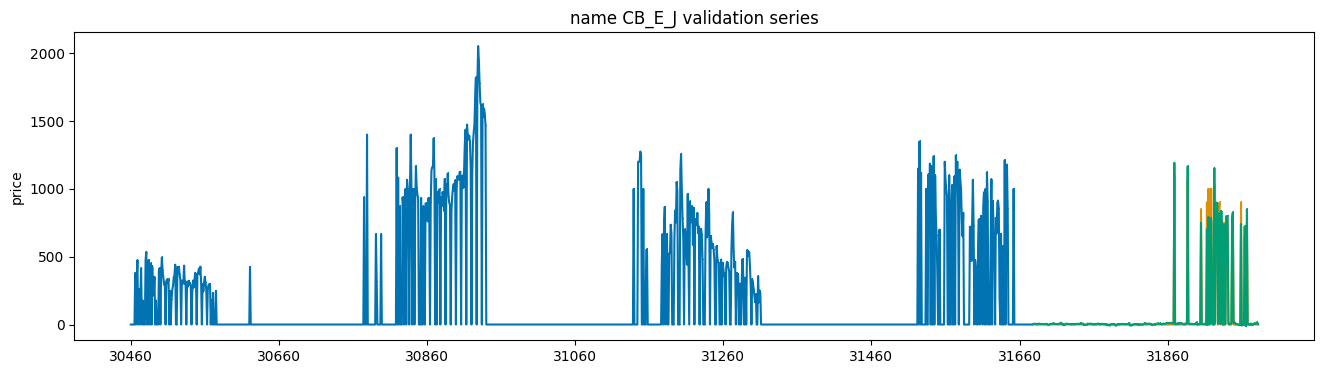

RMSE: 16.58987554793321


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 54%|█████▍    | 21/39 [06:57<05:08, 17.14s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

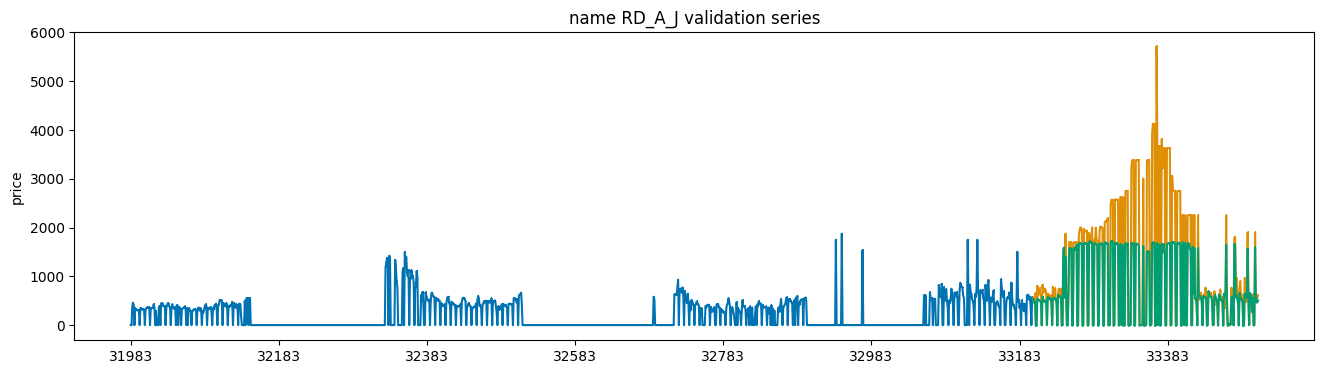

RMSE: 15.11608642104836


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 56%|█████▋    | 22/39 [07:15<04:54, 17.32s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

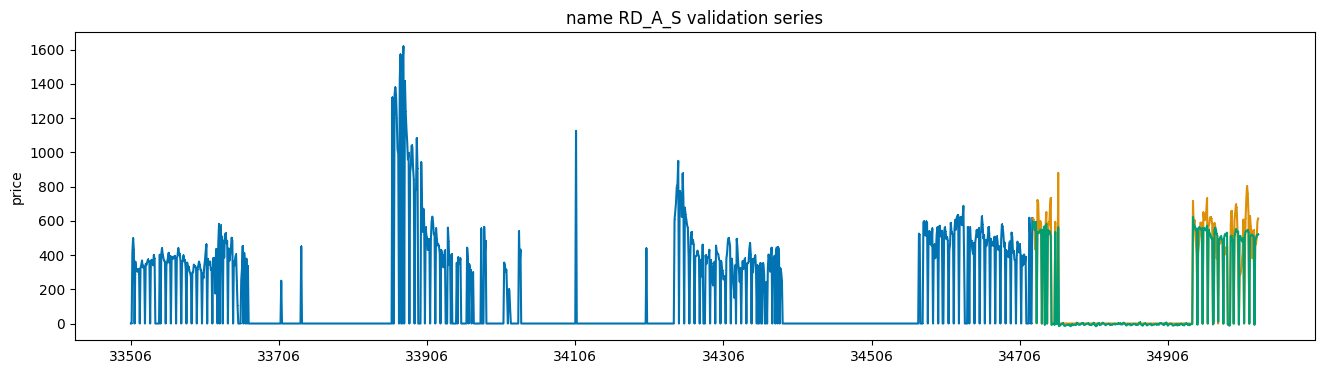

RMSE: 13.657117507602521


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 59%|█████▉    | 23/39 [07:33<04:40, 17.52s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

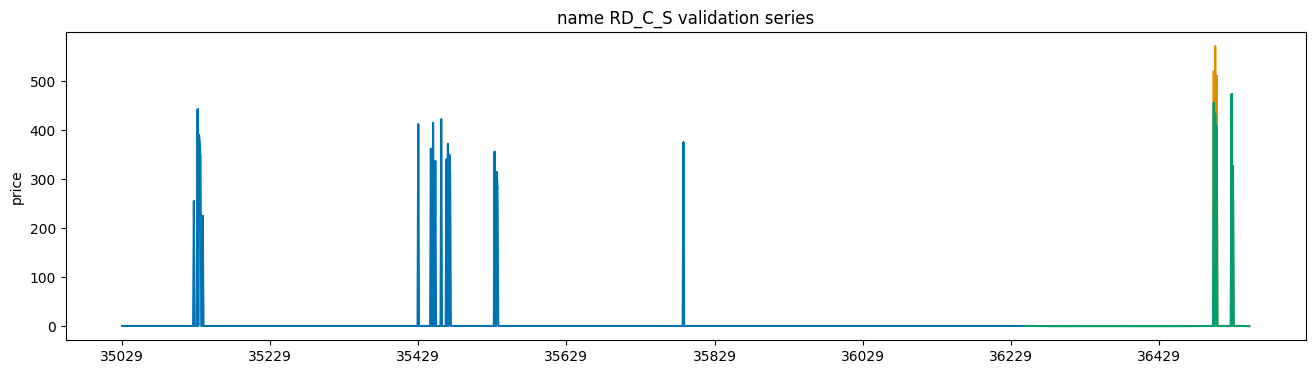

RMSE: 3.299014438417224


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 62%|██████▏   | 24/39 [07:47<04:07, 16.47s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

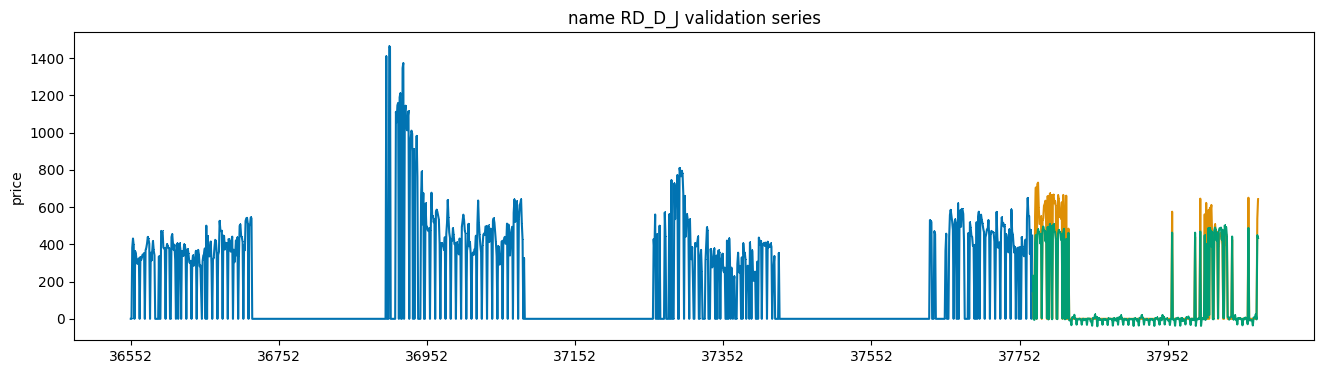

RMSE: 9.122338571829088


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 64%|██████▍   | 25/39 [08:05<03:55, 16.83s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

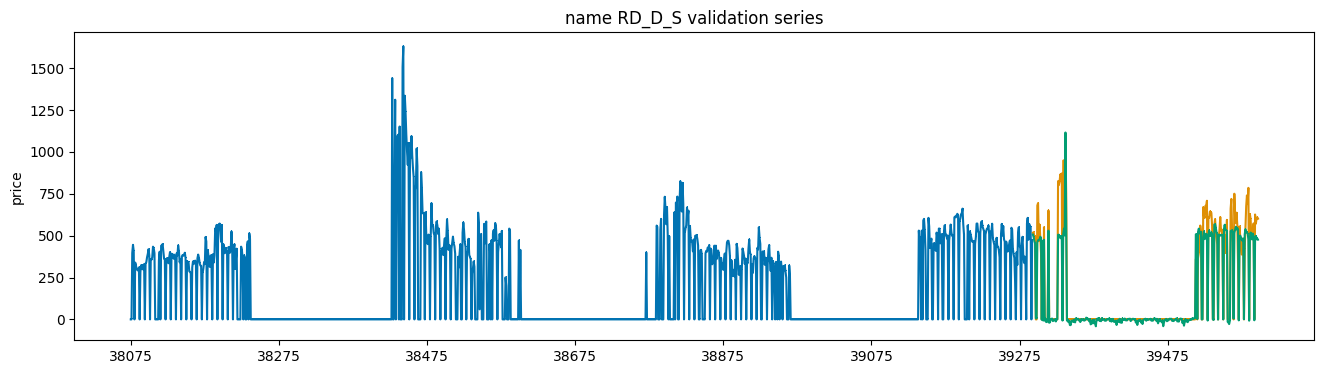

RMSE: 9.812778041568551


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 67%|██████▋   | 26/39 [08:23<03:44, 17.28s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

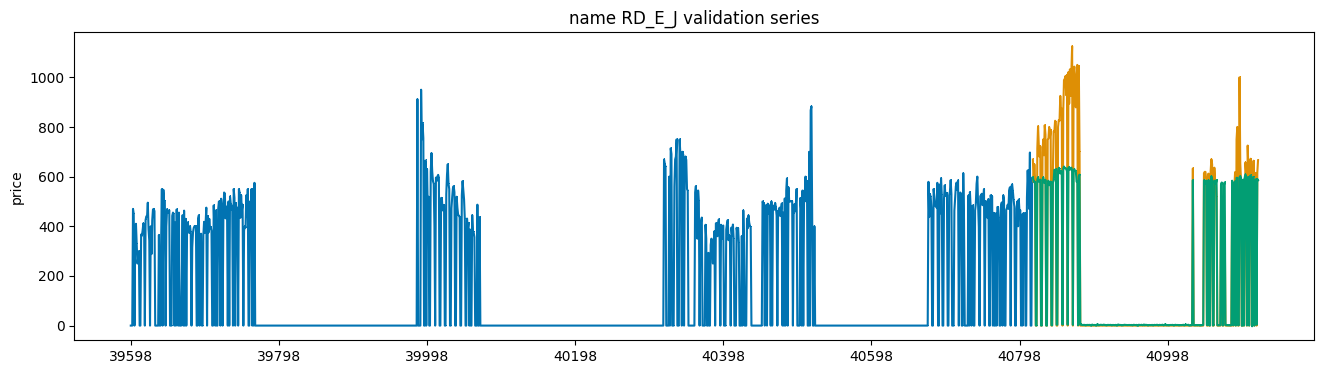

RMSE: 13.256862379736742


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 69%|██████▉   | 27/39 [08:40<03:27, 17.26s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

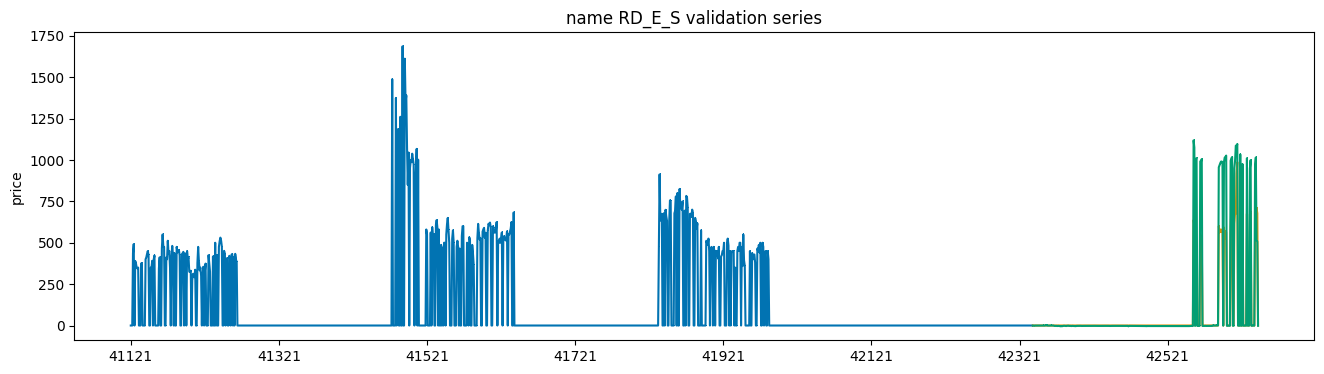

RMSE: 9.777346053237133


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 72%|███████▏  | 28/39 [08:55<03:03, 16.64s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

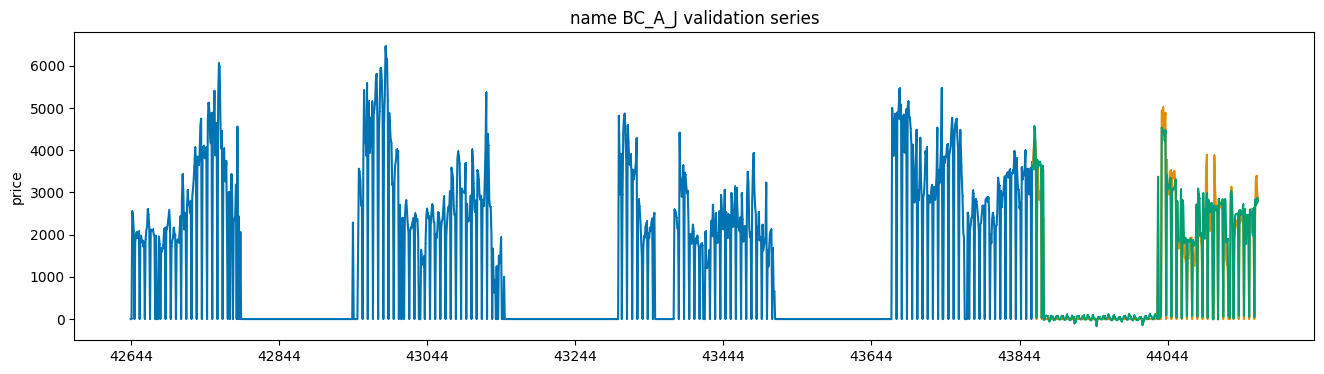

RMSE: 54.97208610263167


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 74%|███████▍  | 29/39 [09:15<02:54, 17.42s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

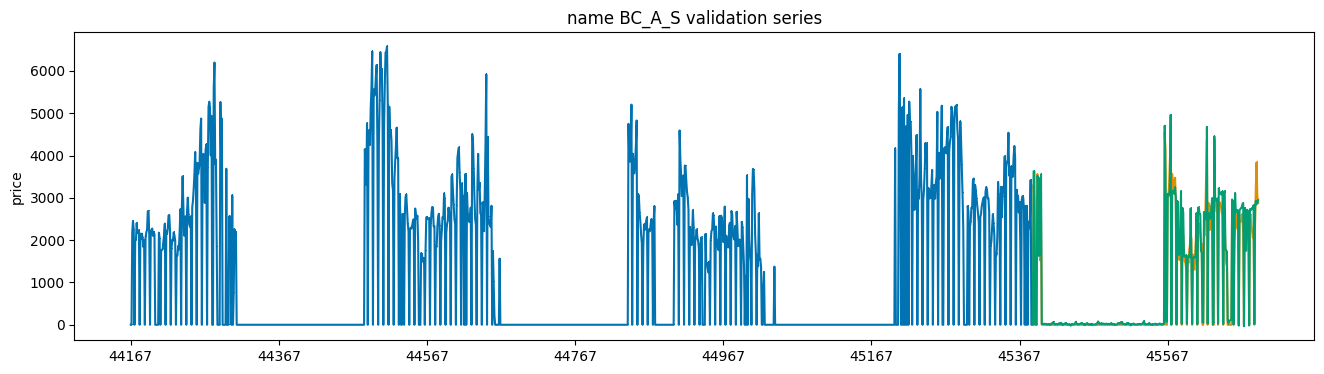

RMSE: 60.48585512176604


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 77%|███████▋  | 30/39 [09:33<02:38, 17.57s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

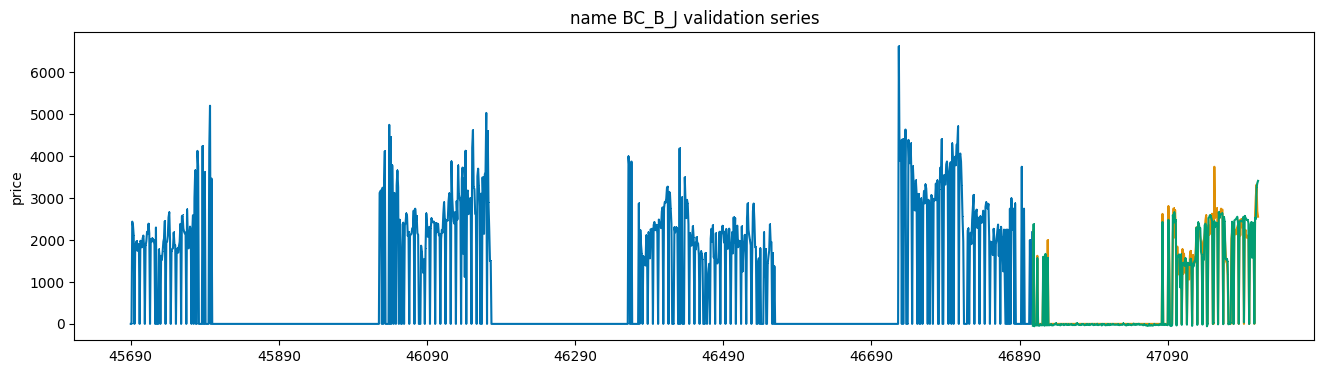

RMSE: 48.1277633021749


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 79%|███████▉  | 31/39 [09:51<02:23, 17.88s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

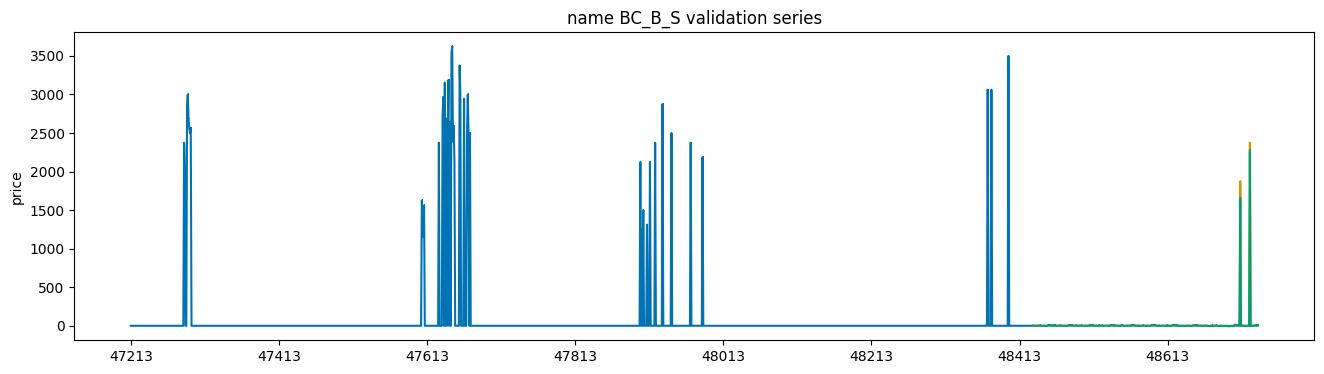

RMSE: 27.085905448013733


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 82%|████████▏ | 32/39 [10:07<02:00, 17.18s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

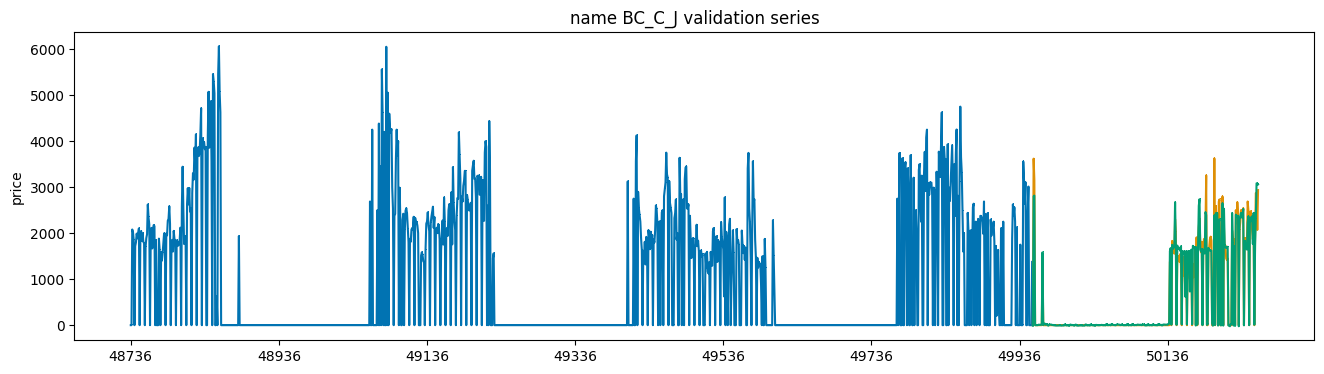

RMSE: 69.19338434719295


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 85%|████████▍ | 33/39 [10:27<01:48, 18.11s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

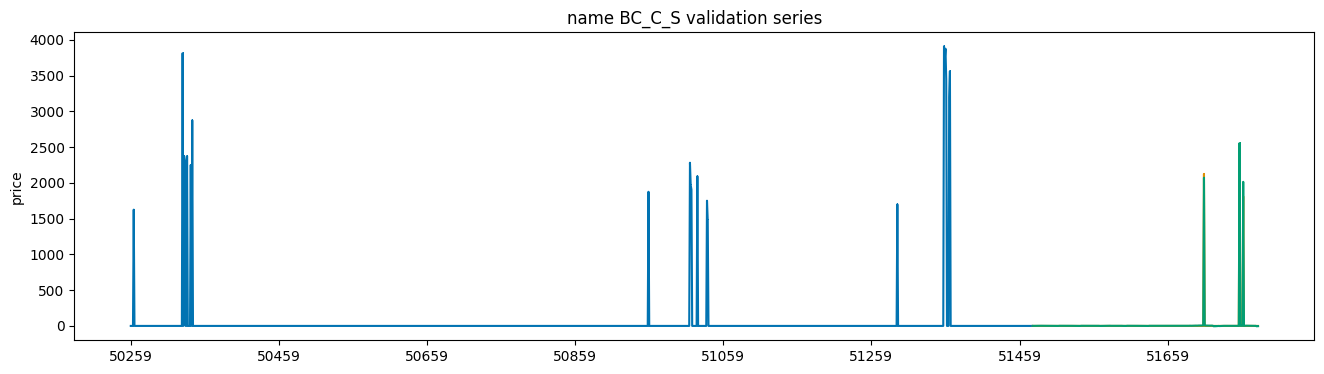

RMSE: 19.776374817619086


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 87%|████████▋ | 34/39 [10:41<01:24, 16.98s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

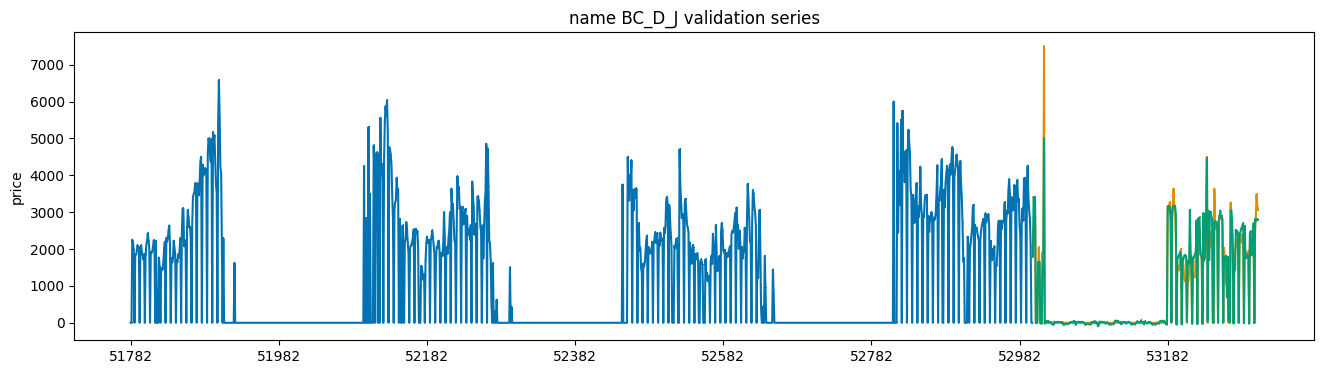

RMSE: 87.69478832562535


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 90%|████████▉ | 35/39 [11:01<01:10, 17.71s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

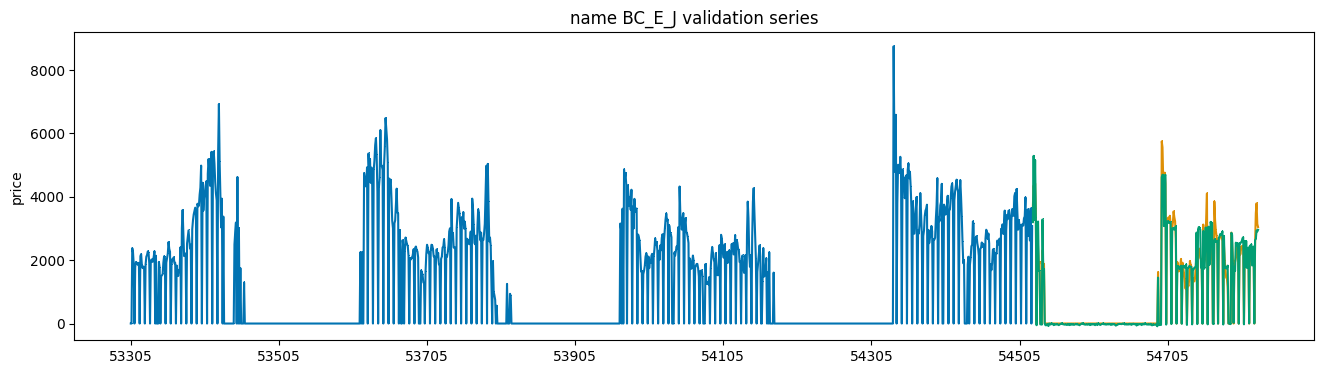

RMSE: 112.39481969975296


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 92%|█████████▏| 36/39 [11:20<00:54, 18.16s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

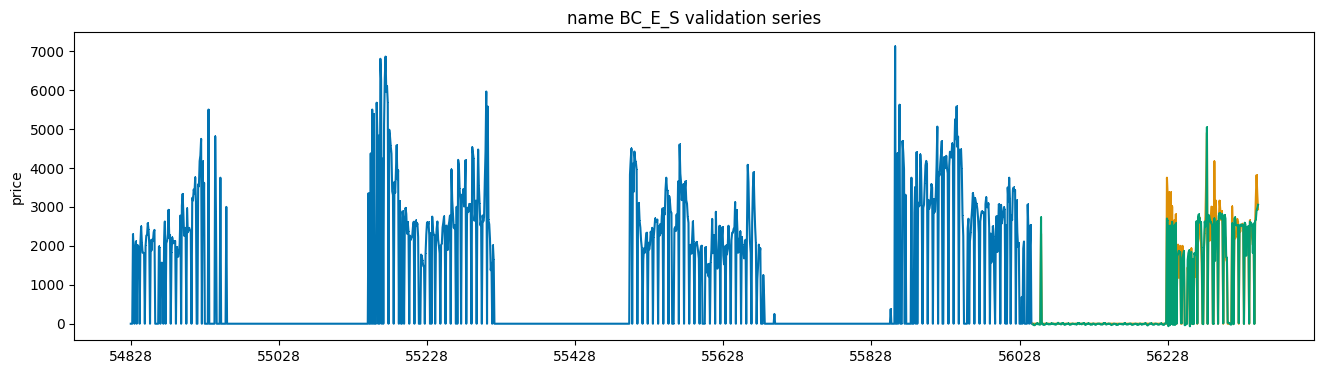

RMSE: 82.96594378402845


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 95%|█████████▍| 37/39 [11:39<00:36, 18.28s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

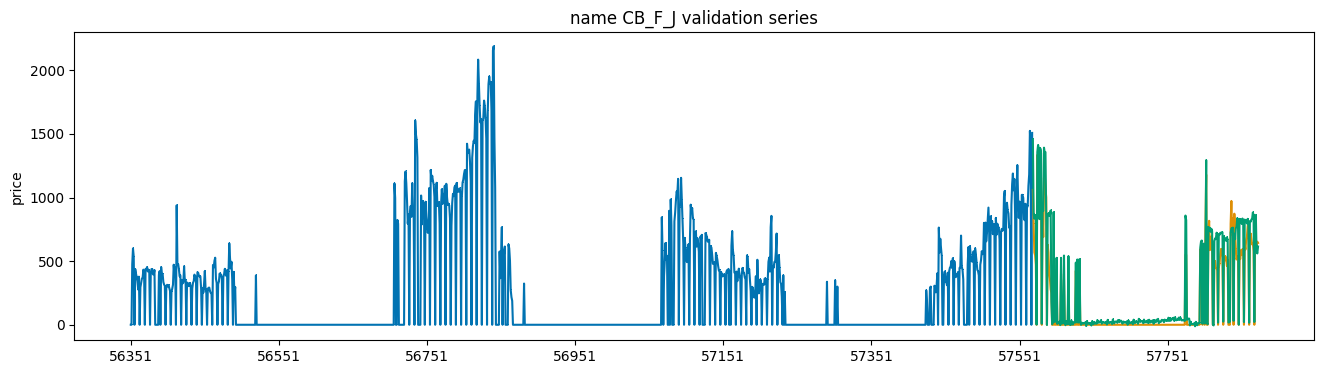

RMSE: 15.723827607680485


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
 97%|█████████▋| 38/39 [11:59<00:18, 18.82s/it]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn

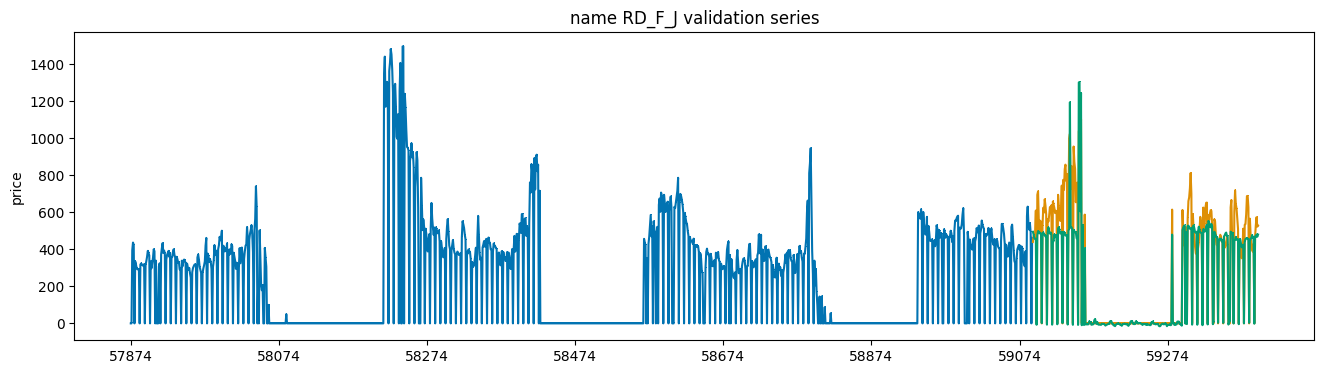

RMSE: 10.280864172519111


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
100%|██████████| 39/39 [12:17<00:00, 18.91s/it]


In [87]:
# import optuna
from sklearn.model_selection import TimeSeriesSplit

# best_params_dict = {}
# predictions_dict = {}
predictions = []
rmse_scores = []

for i in tqdm(train_df.name.unique()):
    X = train_df[train_df.name == i].drop(columns=['ID', 'price', 'supply', 'name'])
    y = train_df[train_df.name == i]['price']
    test_X = test_df[test_df.name == i].drop(columns=['ID', 'name'])


    X_train, X_valid, y_train, y_valid = temporal_train_test_split(X, y, test_size=0.2)

#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=70)  # 적절한 n_trials 값 선택

    # 최적의 하이퍼파라미터 저장
#     best_params_dict[i] = study.best_params

    from sklearn.ensemble import StackingRegressor

    estimators = [
        ("rf", RandomForestRegressor(random_state=SEED)),
        ("lgbm",LGBMRegressor(random_state=SEED)),
        ("xgboost",XGBRegressor(random_state=SEED)),
        ("cat",CatBoostRegressor(random_state=SEED,iterations=200, verbose = 0))
    ]

    params = {
        "estimators" : estimators,
    #     "final_estimator" : LinearRegression(**best_params),
        "final_estimator" : LinearRegression(),
        "cv" : cv,
        "n_jobs":-1
    }

    model_ensemble= StackingRegressor(**params)

    model_ensemble.fit(X_train, y_train)
    X_pred = model_ensemble.predict(X_train)
    X_rmse = np.sqrt(mean_squared_error(y_train, X_pred))
    rmse_scores.append(X_rmse)

    pred = model_ensemble.predict(X_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    plt.title(f'name {i} validation series')
    plt.show()
    print(f'RMSE: {X_rmse}')

    model_ensemble.fit(X,y)
    pred_target = model_ensemble.predict(test_X)
    predictions.append(pred_target)

    # predictions_dict[i] = pd.Series(pred)





In [75]:
train_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply', 'price',
       'year', 'week', 'day', 'month_ori', 'day_of_week', 'sin_week',
       'cos_week', 'sin_dayofweek', 'cos_dayofweek', 'holiday', 'month',
       'month_price_mean', 'month_price_max', 'month_supply_mean',
       'month_supply_max', 'exWeight', 'exValue', 'imWeight', 'imValue',
       'tradeBalance', 'exPrice', 'imPrice', 'item_mean_price',
       'corp_mean_price', 'location_mean_price', 'price_category',
       'supply_category', 'price_category_mean', 'supply_category_mean',
       'name'],
      dtype='object')

In [76]:
test_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'year', 'week',
       'day', 'month_ori', 'day_of_week', 'sin_week', 'cos_week',
       'sin_dayofweek', 'cos_dayofweek', 'holiday', 'month',
       'month_price_mean', 'month_price_max', 'month_supply_mean',
       'month_supply_max', 'exWeight', 'exValue', 'imWeight', 'imValue',
       'tradeBalance', 'exPrice', 'imPrice', 'item_mean_price',
       'corp_mean_price', 'location_mean_price', 'price_category',
       'supply_category', 'price_category_mean', 'supply_category_mean',
       'name'],
      dtype='object')

In [1]:
sum(rmse_scores) / len(rmse_scores)

NameError: name 'rmse_scores' is not defined

In [78]:
predictions

[array([3500.92056944,   46.8847617 , 4967.48057395, 5052.97733941,
        5168.22173809, 3250.32717003, 3332.3521838 , 3267.40876814,
          50.52118284, 5301.22386209, 5341.16587773, 5133.87047245,
        3026.29722868, 3244.42394362, 3087.5134323 ,   10.85636121,
        5280.68052624, 5442.65603443, 5254.93133728, 3234.10956412,
        3393.76913265, 3344.1140861 ,   38.10290812, 5875.62986915,
        5904.67704539, 5703.47638557, 3539.7128893 , 3531.95015648]),
 array([3901.78184727,  142.94801959, 4725.22265649, 4843.8396133 ,
        4883.00398855, 3940.39024775, 3784.90556991, 3820.69774617,
         149.68912401, 4846.59617046, 4993.61708183, 5012.19543587,
        3877.56499998, 3900.56191059, 3847.95996223,  108.65950318,
        5077.74589535, 5277.63911152, 5191.0603945 , 3870.36451109,
        3864.19391905, 3929.18960048,  143.40530377, 5225.21252961,
        5303.65097524, 5289.94558415, 3776.54849596, 3770.48454791]),
 array([3365.95139375,  120.48188173, 5699.9

In [ ]:
total_prediction = []

for i in predictions:
    for j in i :
        total_prediction.append(j)


In [ ]:
for i in total_prediction :
    print(i)

In [ ]:
len(total_prediction)

In [ ]:
total_prediction = np.array(total_prediction)

In [ ]:
total_prediction[total_prediction < 0] = 0

In [ ]:
total_prediction

In [ ]:
submission['answer'] = total_prediction
submission

In [ ]:
submission.to_csv('submission22_1112.csv', index=False)